In [1]:
using Distributions
using ProfileView
using StatsFuns
using Gadfly
using ProgressMeter
using DataFrames
using DataStructures

In [2]:
type Individual
    m::Int64
    p::Int64
    mu::Float64
    mu_b::Float64
    mu_sigma::Float64
    maturity::Int64
    y::Array{Float64, 1}
    b::Array{Int64, 2}
    z::Array{Float64, 1}
    age::Int64
    Individual(m, p, mu, mu_b, mu_sigma, maturity) = new(2*m, p, mu, mu_b, mu_sigma, maturity)
end  

type Population
    n::Int64
    base_ind::Individual
    generation::Int64
    fitness::Array{Float64, 1}
    a_surface::Distributions.FullNormal
    j_surface::Distributions.FullNormal
    pop::Array{Individual, 1}
    moments::Array{Any, 1}
    is_adult::Array{Bool, 1}
    the_departed::Array{Int64, 1}
    Population(n, base_ind, generation) = new(n, base_ind, generation)
end

In [3]:
function RandomInd!(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    ind.y = rand(Normal(y_mean, g_sigma), ind.m)
    ind.b = rand(Bernoulli(), ind.p, ind.m)
    ind.z = ind.b * ind.y
    ind.age = rand(1:100)
end

function RandomInd(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    new_ind = Individual(ind.m/2, ind.p, ind.mu, ind.mu_b, ind.mu_sigma, ind.maturity)
    RandomInd!(new_ind, y_mean, g_sigma)
    new_ind
end

RandomInd (generic function with 3 methods)

In [4]:
function Population(n::Int, ind::Individual, pop_array::Array{Individual, 1})
    new_pop = Population(n, ind, 0)
    new_pop.generation = 0
    new_pop.pop = pop_array
    new_pop.moments = []
    new_pop
end

function RandomPop!(pop::Population, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    pop.pop = Array(Individual, pop.n)
    pop.generation = 0
    for i = 1:pop.n
        pop.pop[i] = RandomInd(pop.base_ind, y_mean, g_sigma)
    end
    pop.moments = []
    pop.fitness = zeros(Float64, pop.n)
    pop.the_departed = []
    pop.is_adult = [(pop.pop[i].age > pop.base_ind.maturity) ? true : false for i in 1:pop.n]
end

RandomPop! (generic function with 3 methods)

In [5]:
import Base.copy!
function copy!(source::Population, sink::Population)
    sink.n            = source.n
    sink.base_ind     = source.base_ind
    sink.generation   = source.generation
    sink.fitness      = source.fitness
    sink.a_surface    = source.a_surface
    sink.j_surface    = source.j_surface
    sink.pop          = source.pop
    sink.is_adult     = source.is_adult
    sink.the_departed = source.the_departed
    sink.moments      = copy(source.moments)
end

import Base.copy
function copy(source::Population)
    new_pop = Population(source.n, source.base_ind, source.generation)
    copy!(source, new_pop)
    new_pop
end

copy (generic function with 72 methods)

In [6]:
import Base.string
function string(pop::Population)
    return "a Population with $(pop.n) individuals, at time step $(pop.generation)"
end

import Base.print
print(io::IO, pop::Population) = print(io, string(pop))

import Base.show
show(io::IO, pop::Population) = print(io, "This is ", pop)



import Base.getindex
function getindex(pop::Population, i::Integer)
    getindex(pop.pop, i)
end

function getindex(pop::Population, s::UnitRange)
    Population(length(s), pop.base_ind, getindex(pop.pop, s))
end

invlogit(x::Float64) = exp(-logsumexp([0, -x]))
invlogit(x::Array{Float64,1}) = map(invlogit, x)

invlogit (generic function with 2 methods)

In [7]:
function twoModuleMatrix(vars::Array{Float64, 1}, cor1, cor2)
    n = size(vars)[1]
    n_1 = Int(floor(n/2))
    module_1 = [ones(Float64, n_1); zeros(Float64, n - n_1)]
    module_2 = [zeros(Float64, n_1); ones(Float64, n - n_1)]
    omega = (module_1 * module_1') * cor1 + module_2 * module_2' * cor2
    [omega[i, i] = 1 for i = 1:n]
    omega .* (sqrt(vars) * sqrt(vars)')
end

function fitness!(pop::Population)
    logfit = Float64[logpdf(pop.is_adult[i] ? pop.a_surface : pop.j_surface, pop[i].z) for i in 1:pop.n]
    [logfit[i] = -10e10 for i in pop.the_departed]
    sum_log_a_fit = logsumexp(logfit[ pop.is_adult])
    sum_log_j_fit = logsumexp(logfit[!pop.is_adult])
    pop.fitness = exp(logfit - [(pop.is_adult[i] ? sum_log_a_fit : sum_log_j_fit) for i in 1:pop.n])
end

function changeSurface!(pop::Population, 
                        a_theta::Array{Float64, 1}, a_omega::Array{Float64, 2},
                        j_theta::Array{Float64, 1}, j_omega::Array{Float64, 2})
    pop.a_surface = MvNormal(a_theta, a_omega)
    pop.j_surface = MvNormal(j_theta, j_omega)
end

changeSurface! (generic function with 1 method)

In [8]:
function mutation!(ind::Individual)
    bin_y = Binomial(ind.m, ind.mu)
    bin_b = Binomial(ind.m * ind.p, ind.mu_b)
    mutation_y = rand(bin_y)
    if(mutation_y > 0)
        d_uni_y = DiscreteUniform(1, ind.m)
        norm_sigma = Normal(0, ind.mu_sigma)
        for k = range(1, mutation_y)
            i = rand(d_uni_y)
            ind.y[i] = ind.y[i] + rand(norm_sigma)
        end
    end
    mutation_b = rand(bin_b)
    if(mutation_b > 0)
        d_uni_p = DiscreteUniform(1, ind.p)
        d_uni_m = DiscreteUniform(1, ind.m)
        for k = range(1, mutation_b)
            i = rand(d_uni_p)
            j = rand(d_uni_m)
            ind.b[i, j] = ind.b[i, j] == 1 ? 0 : 1
        end
    end
end

function cross!(ind_1::Individual, ind_2::Individual, new_ind::Individual,
                d_uni, alele_1::Array{Int64, 1}, alele_2::Array{Int64, 1})
    rand!(d_uni, alele_1)
    rand!(d_uni, alele_2)
    for locus = range(2, 2, convert(Int64, ind_1.m/2))
        new_ind.y[   locus - 1] = ind_1.y[   (locus - 1) + alele_1[convert(Int64, locus/2)]]
        new_ind.y[   locus]     = ind_2.y[   (locus - 1) + alele_2[convert(Int64, locus/2)]]
        for j in range(1, ind_1.p)
            new_ind.b[j, locus - 1] = ind_1.b[j, (locus - 1) + alele_1[convert(Int64, locus/2)]]
            new_ind.b[j, locus]     = ind_2.b[j, (locus - 1) + alele_2[convert(Int64, locus/2)]]
        end
    end
    mutation!(new_ind)
    new_ind.z = new_ind.b * new_ind.y
    new_ind.age = 0
end

cross! (generic function with 1 method)

In [9]:
function mortality!(pop::Population)
    survival_prob = [invlogit((pop.fitness[i]/maximum(pop.is_adult[i] ? pop.fitness[pop.is_adult] : pop.fitness[pop.is_adult])  * 10 - 5)) for i in 1:pop.n]
    pop.the_departed = union(pop.the_departed, find(x -> x == 1, [rand(Bernoulli(1-survival_prob[i])) for i in 1:pop.n]))
end

mortality! (generic function with 1 method)

In [10]:
function next_time_step!(pop::Population, d_uni, alele_1, alele_2; selective = true)
    if (selective)
        fitness!(pop)
    else
        [pop.fitness[i] = pop.is_adult[i] ? 1./sum(pop.is_adult) : 1./sum(!pop.is_adult) for i in 1:pop.n]
    end
    
    key = collect(1:pop.n)[pop.is_adult]
    mortality!(pop)
    
    if any(pop.is_adult)
        for ind in pop.the_departed
            sire = (key[find(x -> x == 1, rand(Multinomial(1, pop.fitness[pop.is_adult]), 1))])[1]
            dam  = (key[find(x -> x == 1, rand(Multinomial(1, pop.fitness[pop.is_adult]), 1))])[1]
            cross!(pop.pop[sire], pop.pop[dam], pop.pop[ind], d_uni, alele_1, alele_2)
        end
        pop.the_departed = []
    end
        
    for i in 1:pop.n
        pop.pop[i].age = pop.pop[i].age + 1
    end
    pop.is_adult = [(pop.pop[i].age > pop.base_ind.maturity) ? true : false for i in 1:pop.n]
    pop.generation = pop.generation + 1
end 

next_time_step! (generic function with 1 method)

In [11]:
function moments!(pop::Population)
    pop.moments = [pop.moments; moments(pop)]
end

function moments(pop::Population)
    ys = convert(Array{Float64, 2}, reshape(Float64[ind.y[i] for ind in pop.pop, i in 1:pop.base_ind.m], pop.n, pop.base_ind.m))
    zs = convert(Array{Float64, 2}, reshape(Float64[ind.z[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    mean_b = zeros(Float64, pop.base_ind.p, pop.base_ind.m)
    for i in 1:pop.n
        mean_b = mean_b + pop[i].b
    end
    mean_y = squeeze(mean(ys, 1), 1)
    mean_z = squeeze(mean(zs, 1), 1)
    mean_b = mean_b / pop.n

    P = cov(zs)
    corrP = cor(zs)
    
    n_adults    = sum(pop.is_adult)/pop.n
    n_juveniles = 1 - n_adults 
    
    Dict([("mean_y", mean_y), 
          ("mean_b", mean_b), 
          ("mean_z", mean_z),
          ("zs", zs), 
          ("theta", pop.a_surface.μ),
          ("gen", pop.generation),
          ("P", P), 
          ("corrP", corrP),
          ("adults", n_adults),
          ("juveniles", n_juveniles)])
end

moments (generic function with 1 method)

In [12]:
function lowerTri(mat)
    p = size(mat)[1]
    lower = zeros(Float64, Int64((p * p - p)/2))
    k = 1
    for i = 1:p, j = 1:p
        if(i < j) 
            lower[k]= mat[i, j]
            k = k + 1
        end
    end
    lower
end

function AVGcorr(mat; modules = Array[collect(1:Int(floor(size(mat)[1]/2))), 
                                      collect(((Int(floor(size(mat)[1]/2)))+1):size(mat)[1])])
    p = size(mat)[1]
    avg_plus = [mean(lowerTri(mat[mod, mod])) for mod in modules]
    modules_array = Array(Int64, p, p, length(modules))
    for j in 1:length(modules)
        mod_vec = [any(i .== modules[j]) ? 1 : 0 for i in 1:p]
        modules_array[:, :, j] = mod_vec * mod_vec'
    end
    avg_plus, mean(mat[find(sum(modules_array, 3) .== 0)])
end

function plotSurfacePop(pop::Population; gen = length(pop.moments))
    zs = pop.moments[gen]["zs"] 
    theta = pop.moments[gen]["a_theta"] 
    zs_eig = (eig(pop.surface.Σ.mat)[2][:, end-1:end]' * zs')'

    zs_df = DataFrame(x = zs_eig[:,1], y = zs_eig[:,2], fit = pop.fitness)
    sort!(zs_df,  cols = [:fit])

    s_theta = eig(pop.surface.Σ.mat)[2][:, end-1:end]' * theta
    s_omega = diagm(eig(pop.surface.Σ.mat)[1])[end-1:end,end-1:end]

    limits_x = (reduce(min, [s_theta[1] - 2*sqrt(s_omega[1, 1]); zs_eig[:,1]]),
                reduce(max, [s_theta[1] + 2*sqrt(s_omega[1, 1]); zs_eig[:,1]]))
    limits_y = (reduce(min, [s_theta[2] - 2*sqrt(s_omega[2, 2]); zs_eig[:,2]]),
                reduce(max, [s_theta[2] + 2*sqrt(s_omega[2, 2]); zs_eig[:,2]]))

    plot(layer(z = (x,y) -> pdf(MvNormal(s_theta, s_omega), [x; y]),
               x = linspace(limits_x[1], limits_x[2], 150), y = linspace(limits_y[1], limits_y[2], 150), 
               Geom.contour),
         layer(zs_df, x = "x", y = "y", color = "fit", Geom.point))
end

plotSurfacePop (generic function with 1 method)

In [13]:
function run_pop(ind::Individual,
                 n_e::Int64,
                 selectionRegimes::Array{String,1},
                 regimeGenerations::Array{Int64, 1};
                 a_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 a_delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 a_omega::Array{Float64, 2} = diagm(ones(Float64, ind.p)), 
                 j_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 j_delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 j_omega::Array{Float64, 2} = diagm(ones(Float64, ind.p)), 
                 thin = 100)
    
    pop = Population(n_e, ind, 0)
    RandomPop!(pop)

    changeSurface!(pop, 
                   a_theta, a_omega,
                   j_theta, j_omega)

    fitness!(pop)
    
    run_pop(pop, selectionRegimes, regimeGenerations; 
            a_theta = a_theta, a_delta_theta = a_delta_theta, a_omega = a_omega, 
            j_theta = j_theta, j_delta_theta = j_delta_theta, j_omega = j_omega, thin = thin)
end

function run_pop(pop::Population,
                 selectionRegimes::Array{String,1},
                 regimeGenerations::Array{Int64, 1};
                 a_theta::Array{Float64, 1} = pop.a_surface.μ, 
                 a_delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 a_omega::Array{Float64, 2} = pop.a_surface.Σ,
                 j_theta::Array{Float64, 1} = pop.j_surface.μ, 
                 j_delta_theta::Array{Float64, 1} = zeros(Float64, ind.p), 
                 j_omega::Array{Float64, 2} = pop.j_surface.Σ,
                 thin = 100)
    
    changeSurface!(pop, 
                   a_theta, a_omega,
                   j_theta, j_omega)
    fitness!(pop)
    
    d_uni = DiscreteUniform(0, 1)
    alele_1 = zeros(Int64, Int64(pop.base_ind.m/2))
    alele_2 = zeros(Int64, Int64(pop.base_ind.m/2))
    
    omega_var = a_omega[1, 1]

    regimes = [i for i in zip(selectionRegimes, regimeGenerations)]
    
    for current_regime in regimes
        @showprogress 2 current_regime[1] for i = 1:current_regime[2]
            if(i % thin == 0) 
                moments!(pop)
            end
            if(startswith(normalize_string(strip(current_regime[1]), casefold = true), "dire"))
                a_theta += a_delta_theta
                j_theta += j_delta_theta
                changeSurface!(pop, a_theta, a_omega, j_theta, j_omega)
            end
            next_time_step!(pop, d_uni, alele_1, alele_2, 
            selective = normalize_string(strip(current_regime[1]), casefold = true) != "drift")
        end
    end
    pop
end

run_pop (generic function with 2 methods)

In [57]:
n_e  = 2000
m    = 400
p    = 4
mu   = 0.0005
mu_b = 0.0001
mu_σ = 0.02
maturity = 1

global ind = Individual(m, p, mu, mu_b, mu_σ, maturity)
warm_up = run_pop(ind, 1000, ["Drift"], [1])

This is a Population with 1000 individuals, at time step 1

In [ ]:
omega_var = 10
diag_omega = diagm(omega_var*ones(Float64, ind.p))

burnin_pop = run_pop(ind, n_e, ["Drift", "Stab"], [500, 500]; a_omega = diag_omega, thin = 1)

Drift100% Time: 0:01:55
Stab 85%  ETA: 0:00:18

In [ ]:
delta_theta_speed = 1/1000
delta_theta = delta_theta_speed * [ones(Float64, Int64(ind.p/2)); -1 * ones(Float64, Int64(ind.p/2))]

omega_var = 10
omega = twoModuleMatrix(omega_var*ones(Float64, ind.p), 0.8, 0.8)

direct_pop = Population(n_e, ind, 0)
copy!(burnin_pop, direct_pop)

direct_pop = run_pop(direct_pop, ["Direct", "Stab"], [1000, 1000]; 
                     a_delta_theta = delta_theta, a_omega = omega, 
                     j_delta_theta = delta_theta, j_omega = omega,
                     thin = 1)

In [52]:
pop = direct_pop

This is a Population with 2000 individuals, at time step 3000

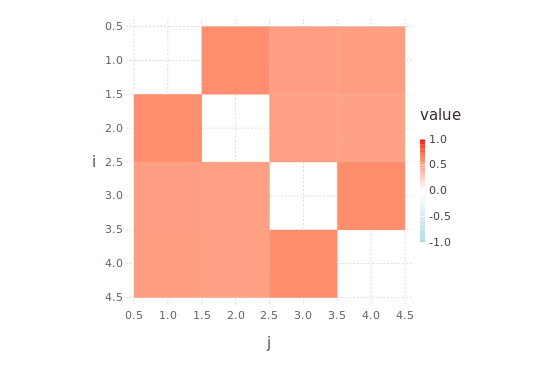

In [53]:
using Colors

a = copy(pop.moments[end]["corrP"])
[a[i, i] = NaN for i in 1:size(a)[1]]
spy(a, Scale.ContinuousColorScale(Scale.lab_gradient(colorant"lightblue",
                                                     colorant"white",
                                                     colorant"red"), minvalue=-1, maxvalue=1))

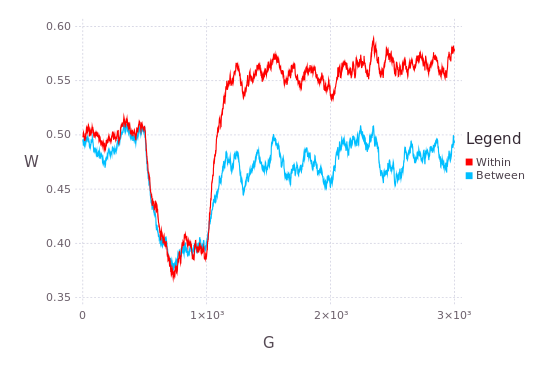

In [54]:
n = length(pop.moments)
df_P = DataFrame(W = [mean(AVGcorr(pop.moments[i]["corrP"])[1]) for i in 1:n],
               B = [AVGcorr(pop.moments[i]["corrP"])[2] for i in 1:n],
               G = collect(1:n) )
plot(df_P, layer(y="W", x="G", Geom.line, Theme(default_color=colorant"red")),
           layer(y="B", x="G", Geom.line),
Guide.manual_color_key("Legend", ["Within", "Between"], ["red", "deepskyblue"]))

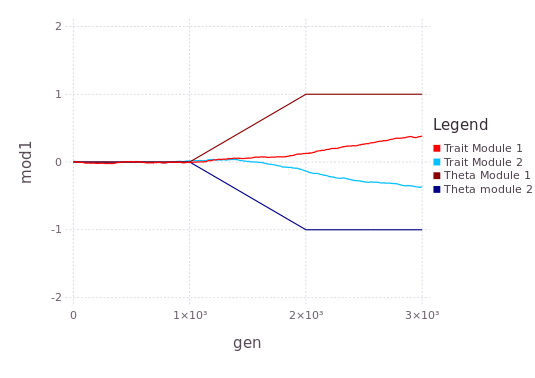

In [55]:
n = size(pop.moments)[1]
p = pop.base_ind.p
df_trait = DataFrame(mod1   = [mean(pop.moments[i]["mean_z"][1:2])     for i in 1:n],
                     theta1 = [mean(pop.moments[i]["theta"][1:2])     for i in 1:n],
                     mod2   = [mean(pop.moments[i]["mean_z"][3:end]) for i in 1:n],
                     theta2 = [mean(pop.moments[i]["theta"][3:end]) for i in 1:n],
                     gen    = collect(1:n) )
plot(df_trait, layer(y="mod1", x="gen", Geom.line, Theme(default_color=colorant"red")),
               layer(y="theta1", x="gen", Geom.line, Theme(default_color=colorant"darkred")),
               layer(y="theta2", x="gen", Geom.line, Theme(default_color=colorant"darkblue")),
               layer(y="mod2", x="gen", Geom.line),
     Guide.manual_color_key("Legend", ["Trait Module 1", "Trait Module 2", "Theta Module 1", "Theta module 2"], 
                            ["red", "deepskyblue", "darkred", "darkblue"]))

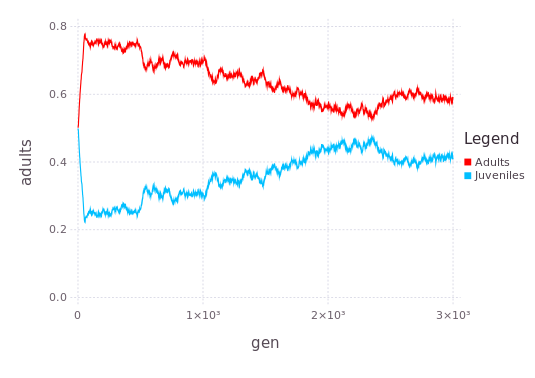

In [56]:
n = size(pop.moments)[1]
df_trait = DataFrame(adults    = [mean(pop.moments[i]["adults"])        for i in 1:n],
                     juveniles = [mean(pop.moments[i]["juveniles"])     for i in 1:n],
                     gen    = collect(1:n) )
plot(df_trait, layer(y="adults", x="gen", Geom.line, Theme(default_color=colorant"red")),
               layer(y="juveniles", x="gen", Geom.line),
     Guide.manual_color_key("Legend", ["Adults", "Juveniles"], 
                            ["red", "deepskyblue"]))

In [ ]:
plotSurfacePop(pop, gen = 1200)

In [ ]:
pop.moments[1]["juveniles"]

In [ ]:
eig(pop.a_surface.Σ.mat)[2][:, end-1:end]' * pop.moments[end]["mean_z"] - eig(pop.a_surface.Σ.mat)[2][:, end-1:end]' * pop.a_surface.μ 

In [ ]:
# Test pop for prototyping
pop = Population(n_e, ind, 0)
RandomPop!(pop)

a_omega = twoModuleMatrix([1., 1., 1., 1.], 0.5, 0.5)
j_omega = twoModuleMatrix([1., 1., 1., 1.], 0., 0.)

changeSurface!(pop, 
               [0., 0., 0., 0.], a_omega,
               [0., 0., 0., 0.], j_omega)

fitness!(pop)